In [1]:
import tensorflow as tf
import numpy as np
from cgan import C_GAN, ResNet9Generator
import matplotlib.pyplot as plt
from numpy import newaxis

print(tf.test.is_gpu_available)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from IPython import display
from ForSim import ForSim
import copy
import time

gan = C_GAN(generator=ResNet9Generator(noise=True))

# load the reference and initial channel models
ch_ref = np.load('./data/ch_ref.npy')

if os.path.exists('./data/cgan_mcmc.npy'):
    cgan_mcmc = np.load('./data/cgan_mcmc.npy')

else:
    cgan_mcmc = np.load('./data/ch_int_1.npy')
    cgan_mcmc = cgan_mcmc[newaxis,:,:]

# load log likelihood if there is one    
logL = np.empty((0,1))
if os.path.exists('./data/cgan_logL.npy'):
    logL = np.load('./data/cgan_logL.npy')
    logL = np.reshape(logL,[-1,1])
                    
[nz,ncmp] = ch_ref.shape

k_cut = 0.15
noise = 1
SNR = 40

AI = np.load('./data/AI_obs_snr%d.npy' %SNR)

d_std = np.sqrt(np.var(AI)/SNR) * 20 # This is arguable, since we are not supposed to know the noise ratio

<function is_gpu_available at 0x14634aa60>
Metal device set to: Apple M1 Pro


2022-12-20 11:43:32.298429: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-20 11:43:32.298537: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


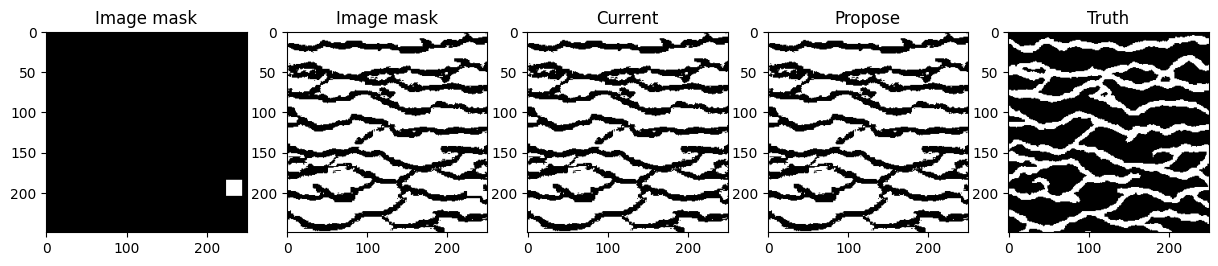

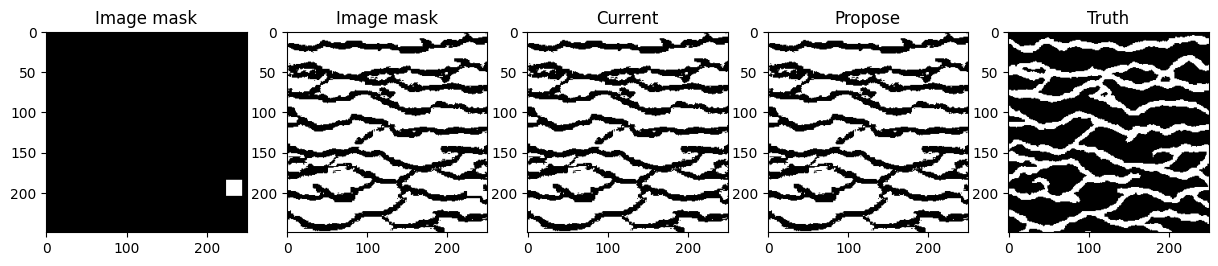

In [2]:
gan = C_GAN(generator=ResNet9Generator(noise=True))

gan.restore_from_checkpoint()

# extended metropolis

grid_size = np.array([nz, ncmp, 1])

AI_sim = ForSim(cgan_mcmc[-1], k_cut, 0, SNR)

logL_current = -0.5 * np.sum(np.square(AI - AI_sim)/np.square(d_std))

logL_propose = 0

ch_current = np.where(cgan_mcmc[-1] == 0, 1, -1)

nite = 50000

interval = 1

lim = np.array([30,30]) #30 30 40 40

display_step = nite/400

logL_step = 1

model_step = 1000

index = 1

ar = 1

for i in range(nite):
        
    print("Iteration #{};".format(i+1),"logL_current is {:.2f};".format(logL_current),"logL_propose is {:.2f};".format(logL_propose),\
         "window size is {:.1f}".format(lim[0]*2))
    
    pos = np.zeros((2,))
    
    [xx,yy,zz] = np.meshgrid(np.arange(grid_size[1]),np.arange(grid_size[0]),np.arange(grid_size[2]))
    pos[0] = 0 + np.random.rand(1) * grid_size[1]
    pos[1] = 0 + np.random.rand(1) * grid_size[0]
    
#     lim = np.array([5,5]) #30 30
    
    if index == 1:
    
        if (i + 1) >= interval * (100):

            lim = lim - 0.5 #20 20

            interval = interval + 1
        
        if (i + 1) >= 4001:  #4001 6001

            lim = np.array([10,10])
            
    else:
        
        lim = np.array([10,10])  #[10 10]
            
    rows, cols, _ = zip(*np.argwhere((np.abs(xx-pos[0])<lim[0]) & (np.abs(yy-pos[1])<lim[1])))
    
    input_image = np.copy(ch_current)
    input_image[rows, cols] = 1
    
#     print(np.unique(input_image))
#     plt.figure()
#     plt.imshow(input_image,'gray')
    
    img = tf.convert_to_tensor(input_image[newaxis,:,:,newaxis], dtype=tf.float32)
    
    t = time.time()
    
    ch_propose = np.squeeze(np.array(gan.generate_image(img))) 
    
#     print(time.time() - t)
    
    n_rows, n_cols, _ = zip(*np.argwhere((np.abs(xx-pos[0])>=lim[0]) | (np.abs(yy-pos[1])>=lim[1])))
    
    ch_propose[n_rows, n_cols] = input_image[n_rows, n_cols]
    
    ch_propose = np.where(ch_propose < 0, -1, 1)
    
    ch_propose = (1 - ch_propose) / 2
    
    if np.mod(i+1,display_step) == 0:
        plt.figure(num = 1, figsize = (15,10))
        plt.subplot(1,5,1)
        plt.title('Image mask')
        temp = np.zeros((grid_size[0],grid_size[1])) - 1
        temp[rows, cols] = 1
        plt.imshow(temp,'gray')
        
        plt.subplot(1,5,2)
        plt.title('Image mask')
        plt.imshow(input_image,'gray')
        
        plt.subplot(1,5,3)
        plt.title('Current')
        plt.imshow(ch_current,'gray')
        
        plt.subplot(1,5,4)
        plt.title('Propose')
        plt.imshow(np.where(ch_propose == 0, 1, -1),'gray')
        
        plt.subplot(1,5,5)
        plt.title('Truth')
        plt.imshow(ch_ref,'gray')
        
        display.clear_output(wait=True)
        display.display(plt.gcf()) 
        time.sleep(0.1) 
    
#     print(np.unique(ch_propose))
#     plt.figure()
#     plt.imshow(ch_propose,'gray')

    AI_sim = ForSim(ch_propose, k_cut, 0, SNR)
    
    logL_propose = -0.5 * np.sum(np.square(AI - AI_sim)/np.square(d_std))
    
    Pacc = np.exp(logL_propose - logL_current)
    
    u = np.random.rand(1)
    
    if u <= np.minimum(Pacc, 1):
        logL_current = logL_propose
        ch_current = np.where(ch_propose == 0, 1, -1)
        ar = ar + 1
        
    if np.mod(i+1,logL_step) == 0:
        logL = np.vstack((logL, [logL_current]))
        
    if np.mod(i+1,model_step) == 0:  
        cgan_mcmc = np.vstack((cgan_mcmc, (1 - ch_current[newaxis,:,:]) / 2))
        
np.save('cgan_mcmc.npy',np.array(cgan_mcmc))
np.save('cgan_logL.npy',np.array(logL))  

In [3]:
print("Accpetance no. is {};".format(ar))

Accpetance no. is 13243;
